# Expense Analyzer

- Date : 01/02/2020
- Author : Aditya Warnulkar (adwarnulkar@gmail.com)

In [1]:
# expense from finance app
expenses_file = '/Users/adwarnulkar/workspace/finance_modeling/notebooks/expenses_january_2021.xls' # Expense report from Toshl finance

# budget allocation for this month
budget_file = '/Users/adwarnulkar/workspace/finance_modeling/notebooks/budget_january_2021.csv' # Budget file as per your standard of living

# 401k , HSA , ESPP contribution
company_deductions = 1419.66 + 1329.76

# Gross - TAX - company deductions
salary = (5601.7-1815.91) + (5601.7-1799.95) - company_deductions # Take home salary (After TAX/ESPP/HSA/401K)

In [2]:
salary

4838.12

In [3]:
company_deductions

2749.42

In [4]:
import sys
import os
import re

import pandas as pd
import numpy as np

import itertools

import matplotlib.pyplot as plt
%matplotlib inline

from bokeh.io import output_notebook , show
output_notebook()

SYS_PATH = 'C:\\Users\\Aditya\\workspace\\finance_modeling\\'
if SYS_PATH not in sys.path:
    sys.path.append(SYS_PATH)

from src import finance_post_process as fin

Loading BokehJS ...

In [5]:
df_expense = pd.read_excel(expenses_file,skiprows=1)
df_expense.head()

,Date,Account,Category,Tags,Amount,Currency,In main currency,Main currency,Description
0,1/3/21,Cash,Shopping,NaN,30.00,USD,30.00,USD,FIFA 21 from Steam
1,1/3/21,Cash,Office Lunch,NaN,10.78,USD,10.78,USD,Urban Plates
2,1/5/21,Cash,Office Lunch,NaN,11.80,USD,11.80,USD,Mendocino farms
3,1/6/21,Cash,Grocery,NaN,14.53,USD,14.53,USD,Ralph’s
4,1/7/21,Cash,Grocery,NaN,30.71,USD,30.71,USD,Miramar


In [6]:
df_budget = pd.read_csv(budget_file)
df_budget.set_index('Category',inplace=True)

In [7]:
df_expense = df_expense.groupby('Category').sum()['Amount']

In [8]:
df_expense = pd.concat([df_budget,df_expense],axis=1,sort=False)
df_expense.fillna(0,inplace=True)
df_expense['leverage'] = df_expense['budget'] - df_expense['Amount']
df_expense['leverage_perc'] = 100 * df_expense['leverage'] / df_expense['budget']
df_expense = df_expense.replace([np.inf, -np.inf], np.nan)
df_expense.fillna(0,inplace=True)
df_expense

,budget,Amount,leverage,leverage_perc
Home & Utilities,1565,1566.53,-1.53,-0.097764
Office Lunch,200,71.51,128.49,64.245000
Grocery,250,188.09,61.91,24.764000
Food & Drinks,230,178.41,51.59,22.430435
Bills,150,85.04,64.96,43.306667
Car,143,88.00,55.00,38.461538
Shopping,100,297.30,-197.30,-197.300000
Fuel,130,69.75,60.25,46.346154
Gifts,50,35.64,14.36,28.720000


In [9]:
print(f"Monthly Expenditure : ${df_expense.Amount.sum():.2f}")

Monthly Expenditure : $2580.27


In [10]:
print(f"Total Leverage : ${df_expense.leverage.sum():.2f}")

Total Leverage : $237.73


## Plotting
- https://docs.bokeh.org/en/latest/docs/user_guide/categorical.html

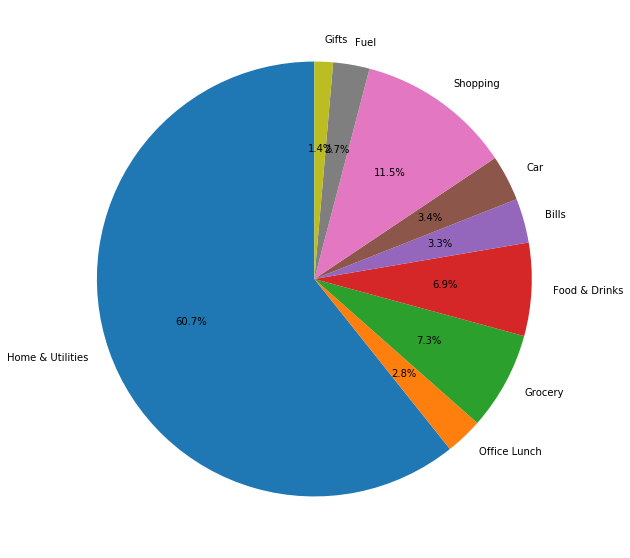

In [11]:
plt.figure(figsize=[10,10])
_ = plt.pie(df_expense.Amount,labels=df_expense.index,shadow=False, startangle=90,autopct='%1.1f%%')

In [12]:
show(fin.plot_expense(df_expense))

# Amount available for investment

In [13]:
salary_take_home = salary
salary_take_home

4838.12

In [14]:
print(f"Total Leverage : ${df_expense.leverage.sum():.2f}")

Total Leverage : $237.73


In [15]:
storage = salary_take_home - df_expense.Amount.sum()
guilt_free_money = 0.1*storage
storage = storage - guilt_free_money
invest_perc = 100*storage/salary_take_home

print(f"Amount available for guilt free expenditure : ${guilt_free_money:.2f}")
print(f"Amount available for investment : ${storage:.2f} {invest_perc:.2f}%")

Amount available for guilt free expenditure : $225.78
Amount available for investment : $2032.06 42.00%


In [16]:
df_goal = pd.read_csv("model_goal_allocation.csv",index_col='goal',usecols=['goal','model_investment'])
df_goal['asset_ratio'] = df_goal.model_investment / df_goal.model_investment.sum()
df_goal['actual_investment'] = df_goal.asset_ratio * storage
df_goal['delta'] = df_goal.actual_investment - df_goal.model_investment
df_goal

,model_investment,asset_ratio,actual_investment,delta
goal,,,,
home,1550.693801,0.507803,1031.888364,-518.805437
vacation,234.204323,0.076694,155.848121,-78.356202
wedding,377.733955,0.123696,251.357987,-126.375968
retirement,891.100000,0.291807,592.970527,-298.129473


In [17]:
df_report = pd.concat([df_expense.Amount,df_goal.actual_investment])

In [18]:
df_report = df_report.append(pd.Series([guilt_free_money],index=['Guilt Free']))

In [19]:
df_report = df_report.to_frame(name='value')
df_report['percentage'] = 100*df_report.value/df_report.value.sum()
df_report["model_value"] = pd.concat([df_expense.budget , df_goal.model_investment])
df_report.fillna(0,inplace=True)
df_report

,value,percentage,model_value
Home & Utilities,1566.530000,32.378899,1565.000000
Office Lunch,71.510000,1.478053,200.000000
Grocery,188.090000,3.887667,250.000000
Food & Drinks,178.410000,3.687589,230.000000
Bills,85.040000,1.757708,150.000000
Car,88.000000,1.818888,143.000000
Shopping,297.300000,6.144949,100.000000
Fuel,69.750000,1.441676,130.000000
Gifts,35.640000,0.736650,50.000000
home,1031.888364,21.328292,1550.693801


In [20]:
df_report.sum()

value          4838.120000
percentage      100.000000
model_value    5871.732079
dtype: float64

In [22]:
df_report.to_csv('/Users/adwarnulkar/workspace/finance_modeling/notebooks/report_january_2021.csv')